Welcome to Week 5 of our seminar on Applied Quantitative Methods in Finance. This week, we will embark on an exciting journey to develop a new factor that captures environmental influences on stock performance, akin to the Fama-French factors. Our goal is to extend the traditional Capital Asset Pricing Model (CAPM) and Fama-French Five-Factor (FF5) models to include environmental considerations, thereby enhancing our understanding of the drivers of stock returns in the context of sustainability.

The primary objective of this week is to understand the process of replicating and creating a factor that can be used in regression models to explain stock price variations.  

For a simple introduction and review of CAPM and multi-factor models, please skim Chapter 8 Multi-Factor Models in Lewinson (2022). This chapter provides additional details and written instructions of how you run CAPM and FF3/FF5 regressions in Python.  (https://learning.oreilly.com/library/view/python-for-finance/9781803243191/Text/Chapter_8.xhtml#_idParaDest-240)   As you follow along this week's examples, you'll be able to refer back to this source for additional explanations as necessary. 

Optional:  The Asset Pricing section in Scheuch et al. (2024) outlines the process in a deeper level of detail.  Feel free to read through this section if you'd like a more holistic understanding of the creation of the FF factors. You can skip the sections "Parallelized Rolling-Window Estimation", "Estimating Beta Using Daily Returns", and "Replicating Fama-French Factors".  (https://www.tidy-finance.org/python/beta-estimation.html)  

Lewinson, E. (2022). Python for Finance Cookbook. Packt Publishing Ltd.

Scheuch, C., Voigt, S., Weiss, P., & Frey, C. (2024). Tidy Finance with Python (1st ed.). Chapman and Hall/CRC, https://www.tidy-finance.org



# Package Imports, WRDS Connection

As usual, we add the key packages we need, configure the notebook and connect to WRDS.

In [135]:
import pandas as pd
pd.set_option('display.max_columns', None) # display all columns

import numpy as np

import os
from dotenv import load_dotenv
from sqlalchemy import create_engine
import pandas_datareader.data as web

import statsmodels.formula.api as smf
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
import matplotlib as mpl

%matplotlib inline

from plotnine import ggplot, aes, geom_point, geom_smooth, facet_wrap, labs, theme_minimal, scale_x_date, geom_smooth
from mizani.formatters import date_format

In [2]:
load_dotenv()
connection_string = (
  "postgresql+psycopg2://"
 f"{os.getenv('WRDS_USER')}:{os.getenv('WRDS_PASSWORD')}"
  "@wrds-pgdata.wharton.upenn.edu:9737/wrds"
)
wrds_engine = create_engine(connection_string, pool_pre_ping=True)

# Background:  CAPM, FF5 and Factor Replication

This section walks through a practical application of the capital asset pricing model (CAPM), the 5-factor model and also demonstrates the creation of a factor by replicating SMB. 

We restrict the timeframe of our analysis to 1980-2022.

In [5]:
start_date = "01/01/1980"
end_date = "12/31/2022"

## CAPM Regression

The Capital Asset Pricing Model (CAPM) is a foundational financial theory that describes the relationship between the expected return of an asset and its risk, as measured by beta. The model posits that the expected return on an investment is equal to the risk-free rate plus a risk premium, which is the product of the asset's beta and the expected market risk premium. CAPM provides a framework for assessing the risk and return of individual securities and helps investors understand the trade-off between risk and expected return in a diversified portfolio, guiding them in making informed investment decisions.

In this section, we calculate Amazon's $\beta$ value based on its exposure to the market (in the U.S. the ticker symbol for the S&P 500 index is ^GSPC). 

In [4]:
asset_ = "AMZN"
market_benchmark = "^GSPC"
start_date = "2016-01-01"
end_date = "2023-12-31"

In [ ]:
yf_market_data = yf.download([asset_, market_benchmark],
                 start=start_date,
                 end=end_date,
                 progress=False)

In [6]:
capm_data = (
    yf_market_data["Adj Close"]
    .rename(columns={asset_: "asset", 
                     market_benchmark: "market"})
    .resample("ME")
    .last()
    .pct_change()
    .dropna()
)

In [7]:
capm_fit = smf.ols(formula="asset ~ market",
                   data=capm_data).fit()

capm_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  asset   R-squared:                       0.410
Model:                            OLS   Adj. R-squared:                  0.404
Method:                 Least Squares   F-statistic:                     64.68
Date:                Sun, 26 May 2024   Prob (F-statistic):           2.76e-12
Time:                        05:09:18   Log-Likelihood:                 120.00
No. Observations:                  95   AIC:                            -236.0
Df Residuals:                      93   BIC:                            -230.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0082      0.007      1.128      0.262      -0.006       0.023
market         1.2425      0.154      8.042      0.000       0.936       1.549
==============================================================================
Omnibus:                        1.662   Durbin-Watson:                   1.891
Prob(Omnibus):                  0.436   Jarque-Bera (JB):                1.088
Skew:                           0.174   Prob(JB):                        0.580
Kurtosis:                       3.392   Cond. No.                         21.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The CAPM regression results for Amazon (AMZN) on the market (^GSPC) indicate a significant relationship between the returns of Amazon and the market. The R-squared value of 0.410 suggests that approximately 41% of the variability in Amazon's returns can be explained by the market returns, which is substantial. The F-statistic of 64.68 with a p-value of 2.76e-12 confirms that the model is statistically significant. The market coefficient ($\beta$) is 1.2425, indicating that Amazon's stock is more volatile than the market; specifically, for every 1% increase in the market return, Amazon's return increases by approximately 1.24%. The intercept of 0.0082 is not statistically significant (p = 0.262), suggesting that the average excess return of Amazon, when the market return is zero, is not significantly different from zero. The diagnostic tests, including the Omnibus, Durbin-Watson, and Jarque-Bera tests, indicate no major issues with normality or autocorrelation in the residuals, supporting the robustness of the regression model.

##  FF5 Regression

The Fama-French Five-Factor Model extends the traditional Capital Asset Pricing Model (CAPM) by incorporating additional factors to better explain the variations in stock returns. This works by including additional variables that capture more dimensions of risk and return, providing a more nuanced understanding of what drives stock performance. When you run a regression using this model, each factor aims to explain a specific aspect of return variation.

These five factors are: 

- Market Risk (mkt_excess), which represents the excess return of the market over the risk-free rate and compensates investors for taking on equity market risk;
- Size (smb, "Small Minus Big"), which measures the historical excess returns of small-cap stocks over large-cap stocks, indicating a tilt towards small-cap performance with a positive coefficient;
- Value (hml, "High Minus Low"), which captures the excess return of value stocks over growth stocks, with a positive coefficient indicating value stock characteristics;
- Profitability (rmw, "Robust Minus Weak"), reflecting the difference in returns between firms with high versus low profitability, where a positive coefficient signals stronger profitability;
- Investment (cma, "Conservative Minus Aggressive"), representing the difference in returns between firms with conservative versus aggressive investment policies, where a positive coefficient suggests a preference for conservative investment strategies. This model provides a more comprehensive framework for understanding the factors that drive stock returns.

Ken French kindly makes pre-calculated factor data available on his website at https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html


We use the example of Amazon again as an example to demonstrate the application of the five factor model. 

In [63]:
asset_ = "AAPL"
start_date = "2010-01-01"
end_date = "2019-12-31"

This data is readily available on Ken French's website, and pandas has a built in function to read it.

In [ ]:
# download Fama French five factors
FF_five_factors = web.DataReader("F-F_Research_Data_5_Factors_2x3",
                             "famafrench",
                                 start=start_date,
                                 end=end_date)[0]

We get our stock returns data from Yahoo Finance.

In [ ]:
# download asset data from yahoo finance
yf_asset_data = yf.download(asset_,
                           start=start_date,
                           end=end_date,
                          )

Resample stock returns from daily to monthly, and calculate returns.

In [66]:
# structure asset returns so they align with Fama French dataset
asset_returns = (yf_asset_data["Adj Close"]
                     .resample("ME") 
                     .last() 
                     .pct_change() 
                     .dropna())
asset_returns.index = asset_returns.index.to_period("M")
asset_returns.name = "asset_ret"

In [67]:
# combine the two dataframes
FF5_returns = (FF_five_factors
               .join (asset_returns) )

In [68]:
# calculate the excess returns and clean up data layout
FF5_returns = (FF5_returns
                  .assign(
                    excess_ret=lambda x: ( x["asset_ret"] - x["RF"])
                  )
                  .rename(columns={"Mkt-RF": "mkt_excess",
                                   "SMB": "smb", 
                                   "HML": "hml", 
                                   "RMW": "rmw", 
                                   "CMA": "cma"})
                  .get(["mkt_excess", "smb", "hml", "rmw", "cma", "excess_ret"])
                  .dropna()
              )

Now we have a data frame with the excess returns an deach of the factors, in monthly observations.

In [69]:
FF5_returns

,mkt_excess,smb,hml,rmw,cma,excess_ret
Date,,,,,,
2010-02,3.40,1.51,3.23,-0.27,1.43,0.065397
2010-03,6.31,1.85,2.21,-0.65,1.69,0.138470
2010-04,2.00,4.98,2.89,0.69,1.72,0.101021
2010-05,-7.89,0.04,-2.44,1.30,-0.21,-0.026124
2010-06,-5.57,-2.47,-4.70,-0.16,-1.55,-0.030827
...,...,...,...,...,...,...
2019-08,-2.58,-3.24,-4.78,0.56,-0.68,-0.176461
2019-09,1.43,0.27,6.75,1.84,3.37,-0.107038
2019-10,2.06,0.26,-1.91,0.44,-0.96,-0.049316


Finally we run the five-factor model regression. 

In [70]:
fit_ = smf.ols(formula="excess_ret ~ mkt_excess + smb + hml + rmw + cma",
                   data=FF5_returns).fit()
fit_.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             excess_ret   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.205
Method:                 Least Squares   F-statistic:                     7.083
Date:                Sun, 26 May 2024   Prob (F-statistic):           8.53e-06
Time:                        05:27:29   Log-Likelihood:                 124.00
No. Observations:                 119   AIC:                            -236.0
Df Residuals:                     113   BIC:                            -219.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0333      0.009     -3.846      0.000      -0.050      -0.016
mkt_excess     0.0114      0.002      4.690      0.000       0.007       0.016
smb            0.0027      0.004      0.665      0.508      -0.005       0.011
hml            0.0029      0.005      0.616      0.539      -0.006       0.012
rmw            0.0162      0.006      2.635      0.010       0.004       0.028
cma           -0.0152      0.007     -2.115      0.037      -0.029      -0.001
==============================================================================
Omnibus:                       18.373   Durbin-Watson:                   0.856
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.029
Skew:                          -0.860   Prob(JB):                     9.99e-06
Kurtosis:                       4.298   Cond. No.                         4.58
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The Fama-French Five-Factor Model regression results for Apple (AAPL) provide a detailed view of the factors influencing its excess returns. The model's R-squared value is 0.239, indicating that approximately 23.9% of the variability in Apple's excess returns is explained by the five factors included in the model. The adjusted R-squared value of 0.205 suggests that, even after accounting for the number of predictors, the model explains a significant portion of the return variability. The overall F-statistic of 7.083 with a p-value of 8.53e-06 indicates that the model is statistically significant.

Examining the coefficients, the intercept is -0.0333 and is highly significant with a p-value of less than 0.0001. This suggests that, on average, Apple's excess return over the risk-free rate is negative when all other factors are zero. The market excess return (mkt_excess) has a coefficient of 0.0114 and is also highly significant (p < 0.0001), indicating a positive relationship between the market return and Apple's excess return. This means that for every 1% increase in the market return, Apple's excess return increases by approximately 1.14%.

The size factor (smb) has a coefficient of 0.0027, but it is not statistically significant (p = 0.508), suggesting that the size effect does not have a meaningful impact on Apple's returns. Similarly, the value factor (hml) has a small positive coefficient of 0.0029 and is not statistically significant (p = 0.539), indicating that Apple's stock does not strongly exhibit characteristics of either a value or growth stock.

The profitability factor (rmw) has a positive and statistically significant coefficient of 0.0162 (p = 0.010), suggesting that Apple's returns are positively influenced by its profitability. This indicates that more profitable firms, like Apple, tend to have higher returns. The investment factor (cma) has a negative and statistically significant coefficient of -0.0152 (p = 0.037), indicating that Apple's returns are negatively associated with more aggressive investment policies. This suggests that firms with more conservative investment policies tend to outperform those with aggressive investment strategies.

The model diagnostics, including the Omnibus and Jarque-Bera tests, indicate potential issues with normality, as evidenced by the significant p-values. The Durbin-Watson statistic of 0.856 suggests positive autocorrelation in the residuals, which may indicate that some information is not captured by the model.

In summary, the Fama-French Five-Factor Model provides a substantial explanatory power for Apple's excess returns, with significant contributions from market risk, profitability, and investment factors. Other factors such as size and value do not show significant impacts. This suggests that Apple's performance is influenced by its market movements, high profitability, and conservative investment strategies. Further model refinement and consideration of other potential influences may be necessary to fully understand the drivers of Apple's stock performance.

It is notable that this analysis is **very** time sensitive.   Try to adjust the end date or start date, and see how your results change. 

## FF Factor Replication

In our next step, we will delve deeper into the Fama-French Five-Factor Model by replicating one of its key components: the Size factor, commonly known as Small Minus Big (SMB). The SMB factor captures the return differential between small-cap stocks and large-cap stocks, reflecting the historical tendency for small-cap stocks to outperform their larger counterparts. By constructing the SMB factor ourselves, we will gain a better understanding of the methodology behind factor construction and the rationale for including such factors in asset pricing models. This exercise will enhance our ability to critically evaluate the Fama-French model and appreciate the nuances of factor-based investing. Through hands-on replication, we will bridge theory with practice, furthering our insights into the dynamics of stock returns and the factors that drive them.

For this excercise, we need data from both Compustat (financial statements) as well as CRSP (asset prices), which we download from WRDS.

### Download Fama French Data

We will compare our factor to the FF factor, to determine replication success.

In [ ]:
factors_ff5_monthly_raw = web.DataReader(
  name="F-F_Research_Data_5_Factors_2x3",
  data_source="famafrench", 
  start=start_date, 
  end=end_date)[0]

factors_ff5_monthly = (factors_ff5_monthly_raw
  .divide(100)
  .reset_index(names="month")
  .assign(month=lambda x: pd.to_datetime(x["month"].astype(str)))
  .rename(str.lower, axis="columns")
  .rename(columns={"mkt-rf": "mkt_excess"})
)

### Establish Compustat/CRSP Linking Table

Compustat and CRSP use different identifiers for the data, Compustat uses a field called gvkey, and CRSP a field called permo.  We  download the cross reference table, so we can combine the data sets later on. 

In [7]:
# because Compustat and CRSP use different identifiers for assets, we need establish a cross reference
#   luckily WRDS provides this for us

ccmxpf_linktable_query = (
  "SELECT lpermno AS permno, gvkey, linkdt, "
         "COALESCE(linkenddt, CURRENT_DATE) AS linkenddt "
    "FROM crsp.ccmxpf_linktable "
    "WHERE linktype IN ('LU', 'LC') "
          "AND linkprim IN ('P', 'C') "
          "AND usedflag = 1"
)

ccmxpf_linktable = pd.read_sql_query(
  sql=ccmxpf_linktable_query,
  con=wrds_engine,
  dtype={"permno": int, "gvkey": str},
  parse_dates={"linkdt", "linkenddt"}
)

### Download Data from Compustat

When downloading data from Compustat, it is crucial to understand the meaning of each variable to effectively use them in constructing the SMB factor. Below are the descriptions of the variables:

- seq (Stockholders' Equity): Represents the total equity of a company, which includes common equity, preferred equity, and retained earnings.
- ceq (Common Equity): The value of equity attributable to common shareholders, which is the difference between total equity and preferred equity.
- at (Total Assets): The sum of all assets owned by a company, including current and non-current assets.
- lt (Total Liabilities): The total amount of liabilities owed by a company, both current and long-term.
- txditc (Deferred Taxes and Investment Tax Credit): The deferred tax liability that is expected to be paid in the future due to temporary differences between accounting and tax income.
- txdb (Deferred Tax Assets): The amount of taxes that have been paid or carried forward but have not yet been recognized on the income statement.
- itcb (Investment Tax Credit): A credit granted by the government to incentivize investment in certain assets or projects.
- pstkrv (Preferred Stock Redemption Value): The value at which preferred stock can be redeemed by the issuing company.
- pstkl (Preferred Stock Liquidating Value): The value of preferred stock if the company were to be liquidated.
- pstk (Preferred Stock): The total value of preferred stock outstanding.
- capx (Capital Expenditures): The funds used by a company to acquire, upgrade, and maintain physical assets such as property, industrial buildings, or equipment.
- oancf (Operating Activities Net Cash Flow): The net cash flow generated from the company’s core operating activities.
- sale (Sales/Revenue): The total revenue generated from the sale of goods and services.
- cogs (Cost of Goods Sold): The direct costs attributable to the production of the goods sold by a company.
- xint (Interest Expense): The cost incurred by a company for borrowed funds.
- xsga (Selling, General, and Administrative Expense): The combined payroll costs, marketing expenses, rent, utilities, and other overhead costs related to selling goods and services and managing the company.

Understanding these variables is essential as we use them to construct the SMB factor, enabling us to analyze the size effect in stock returns. This exercise will involve calculating key metrics such as market capitalization and sorting firms into size portfolios, thereby replicating the methodology used in the Fama-French model.

In [73]:
compustat_query = (
  "SELECT gvkey, datadate, seq, ceq, at, lt, txditc, txdb, itcb,  pstkrv, "
         "pstkl, pstk, capx, oancf, sale, cogs, xint, xsga "
    "FROM comp.funda "
    "WHERE indfmt = 'INDL' "
          "AND datafmt = 'STD' "
          "AND consol = 'C' "
         f"AND datadate BETWEEN '{start_date}' AND '{end_date}'"
)

compustat = pd.read_sql_query(
  sql=compustat_query,
  con=wrds_engine,
  dtype={"gvkey": str},
  parse_dates={"datadate"}
)

Now we process Compustat data to derive key financial metrics necessary for constructing the Fama-French factor. Specifically, we calculate the book equity (BE), operating profitability (OP), and investment ratio (INV).

First, we calculate book equity (BE), which represents the net asset value of a firm. This is done by taking the total assets and subtracting total liabilities, adjusted for various accounting items. We use stockholders' equity (SEQ) or the combination of common equity (CEQ) and preferred stock (PSTK), add deferred tax assets and investment tax credit (TXDITC or TXDB + ITCB), and subtract the preferred stock redemption value (PSTKRV), liquidating value (PSTKL), or preferred stock (PSTK). Negative values of BE are set to NaN to ensure validity.

Next, we calculate the operating profitability (OP), which measures the firm’s profit from core business operations relative to its book equity. OP is calculated as the difference between sales and the sum of cost of goods sold (COGS), selling, general, and administrative expenses (SG&A), and interest expense, divided by book equity (BE).

To ensure we use the most recent data available for each firm-year, we sort the data by the date of the financial statement (DATADATE) and keep only the latest record for each firm-year.

Finally, we compute the investment ratio (INV), which measures the firm's growth in assets. This is calculated as the percentage change in total assets from one year to the next. We create a lagged version of the total assets (AT) by one year and then calculate INV as the ratio of current year assets to the previous year assets, minus one. Cases where the lagged assets are non-positive are handled by setting the INV to NaN.

This detailed process ensures accurate calculation and handling of financial data, setting the stage for further analysis and construction of the SMB factor as part of the Fama-French model.

In [74]:
# calculate the book value of preferred stock and equity be 
compustat = (compustat
  .assign(
    be=lambda x: 
      (x["seq"].combine_first(x["ceq"]+x["pstk"])
       .combine_first(x["at"]-x["lt"])+
       x["txditc"].combine_first(x["txdb"]+x["itcb"]).fillna(0)-
       x["pstkrv"].combine_first(x["pstkl"])
       .combine_first(x["pstk"]).fillna(0))
  )
  .assign(
    be=lambda x: x["be"].apply(lambda y: np.nan if y <= 0 else y)
  )
  .assign(
    op=lambda x: # and the operating profitability op
      ((x["sale"]-x["cogs"].fillna(0)- 
        x["xsga"].fillna(0)-x["xint"].fillna(0))/x["be"])
  )
)

# keep only the last available information for each firm-year group 
compustat = (compustat
  .assign(year=lambda x: pd.DatetimeIndex(x["datadate"]).year)
  .sort_values("datadate")
  .groupby(["gvkey", "year"])
  .tail(1)
  .reset_index()
)

# compute the investment ratio (inv)
compustat_lag = (compustat
  .get(["gvkey", "year", "at"])
  .assign(year=lambda x: x["year"]+1)
  .rename(columns={"at": "at_lag"})
)

compustat = (compustat
  .merge(compustat_lag, how="left", on=["gvkey", "year"])
  .assign(inv=lambda x: x["at"]/x["at_lag"]-1)
  .assign(inv=lambda x: np.where(x["at_lag"] <= 0, np.nan, x["inv"]))
)

### Download Data from CRSP

Now we download data from CRSP, so we are able to link the market behavior to the firm fundamentals. 

- permno: This is the unique permanent number assigned to each security by CRSP. It serves as a stable identifier for tracking securities over time.
- date: This represents the calendar date of the monthly observation. It is derived directly from the mthcaldt field in the CRSP data.
- month: This is the truncated version of the date, representing only the year and month. It is formatted as a date type to facilitate monthly aggregation and analysis.
- ret: The monthly return of the security. This variable captures the percentage change in the price of the security over the month, including dividends.
- shrout: The number of shares outstanding for the security at the end of the month. This value is used to calculate market capitalization and other related metrics.
- altprc: The monthly price of the security, adjusted for corporate actions like splits and dividends. This variable is essential for return calculations and valuation assessments.
- primaryexch: The primary exchange on which the security is traded. This information helps identify the trading venue and potentially infer liquidity and trading volume characteristics.
- siccd: The Standard Industrial Classification (SIC) code of the company issuing the security. SIC codes categorize companies into industries, allowing for industry-specific analysis and comparisons.

In [8]:
crsp_monthly_query = (
  "SELECT msf.permno, msf.mthcaldt AS date, "
         "date_trunc('month', msf.mthcaldt)::date AS month, "
         "msf.mthret AS ret, msf.shrout, msf.mthprc AS altprc, "
         "msf.primaryexch, msf.siccd "
    "FROM crsp.msf_v2 AS msf "
    "LEFT JOIN crsp.stksecurityinfohist AS ssih "
    "ON msf.permno = ssih.permno AND "
       "ssih.secinfostartdt <= msf.mthcaldt AND "
       "msf.mthcaldt <= ssih.secinfoenddt "
   f"WHERE msf.mthcaldt BETWEEN '{start_date}' AND '{end_date}' "
      "AND ssih.sharetype = 'NS' "
      "AND ssih.securitytype = 'EQTY' "  
      "AND ssih.securitysubtype = 'COM' " 
      "AND ssih.usincflg = 'Y' " 
      "AND ssih.issuertype in ('ACOR', 'CORP')"
)

crsp_monthly = (pd.read_sql_query(
    sql=crsp_monthly_query,
    con=wrds_engine,
    dtype={"permno": int, "siccd": int},
    parse_dates={"date", "month"})
  .assign(shrout=lambda x: x["shrout"]*1000)
)

In the following data processing sequence, we prepare the CRSP monthly data for analysis by calculating key metrics and merging necessary financial data.

First, we calculate the market capitalization (mktcap) by multiplying the number of shares outstanding (shrout) by the adjusted price (altprc). This result is then converted to millions for consistency. Any zero values in the market capitalization are replaced with NaN to ensure that missing or invalid data does not skew the analysis.

Next, we calculate the lagged market capitalization (mktcap_lag). This involves shifting the month field by one month forward and retaining the market capitalization value from the previous month. This lagged value is then merged back into the main data frame to provide a historical context for each observation.

We then incorporate monthly excess returns by merging the CRSP data with the Fama-French five-factor model data. This involves calculating the excess return by subtracting the risk-free rate from the monthly return. To handle extreme values, we clip the excess return at a lower bound of -1. After this, we drop the risk-free rate column as it is no longer needed.

Finally, we clean the data by removing any rows with NaN values in the excess return, market capitalization, or lagged market capitalization columns. This ensures that the dataset is complete and ready for subsequent analysis.

In [9]:
# create market capitalization (mktcap) variable, as the product of the number of outstanding shares (shrout) 
#  and the last traded price in a month (altprc).
crsp_monthly = (crsp_monthly
  .assign(mktcap=lambda x: x["shrout"]*x["altprc"]/1000000)
  .assign(mktcap=lambda x: x["mktcap"].replace(0, np.nan)) # replace zeros with NA values
)

# calculate lagged market cap
mktcap_lag = (crsp_monthly
  .assign(
    month=lambda x: x["month"]+pd.DateOffset(months=1),
    mktcap_lag=lambda x: x["mktcap"]
  )
  .get(["permno", "month", "mktcap_lag"])
)
crsp_monthly = (crsp_monthly
  .merge(mktcap_lag, how="left", on=["permno", "month"])
)

# add monthly excess return - calculate it using Fama French market returns
crsp_monthly = (crsp_monthly
  .merge(factors_ff5_monthly, how="left", on="month")
  .assign(ret_excess=lambda x: x["ret"]-x["rf"])
  .assign(ret_excess=lambda x: x["ret_excess"].clip(lower=-1))
  .drop(columns=["rf"])
)

crsp_monthly = (crsp_monthly
  .dropna(subset=["ret_excess", "mktcap", "mktcap_lag"])
)

Clean up some of the CRSP data description to more readable formats.

In [10]:
def assign_exchange(primaryexch):
    if primaryexch == "N":
        return "NYSE"
    elif primaryexch == "A":
        return "AMEX"
    elif primaryexch == "Q":
        return "NASDAQ"
    else:
        return "Other"

crsp_monthly["exchange"] = (crsp_monthly["primaryexch"]
  .apply(assign_exchange)
)

def assign_industry(siccd):
    if 1 <= siccd <= 999:
        return "Agriculture"
    elif 1000 <= siccd <= 1499:
        return "Mining"
    elif 1500 <= siccd <= 1799:
        return "Construction"
    elif 2000 <= siccd <= 3999:
        return "Manufacturing"
    elif 4000 <= siccd <= 4899:
        return "Transportation"
    elif 4900 <= siccd <= 4999:
        return "Utilities"
    elif 5000 <= siccd <= 5199:
        return "Wholesale"
    elif 5200 <= siccd <= 5999:
        return "Retail"
    elif 6000 <= siccd <= 6799:
        return "Finance"
    elif 7000 <= siccd <= 8999:
        return "Services"
    elif 9000 <= siccd <= 9999:
        return "Public"
    else:
        return "Missing"

crsp_monthly["industry"] = (crsp_monthly["siccd"]
  .apply(assign_industry)
)

Now we add the gvkey (Compustat) identifier to the CRSP file, so we can combine the two data tables. 

In [11]:
ccm_links = (crsp_monthly
  .merge(ccmxpf_linktable, how="inner", on="permno")
  .query("~gvkey.isnull() & (date >= linkdt) & (date <= linkenddt)")
  .get(["permno", "gvkey", "date"])
)

crsp_monthly = (crsp_monthly
  .merge(ccm_links, how="left", on=["permno", "date"])
)

### Save / Load Data

In [ ]:
# Save data frames
datastore_ = pd.HDFStore('week5.h5')
datastore_['compustat'] = compustat
datastore_['crsp_monthly'] = crsp_monthly
datastore_['factors_ff5_monthly'] =  factors_ff5_monthly
datastore_['ccmxpf_linktable'] =  ccmxpf_linktable
datastore_.close()

In [4]:
# Load data frames
datastore_ = pd.HDFStore('week5.h5')
compustat = datastore_['compustat'] 
crsp_monthly = datastore_['crsp_monthly'] 
factors_ff5_monthly = datastore_['factors_ff5_monthly'] 
ccmxpf_linktable = datastore_['ccmxpf_linktable'] 
datastore_.close()  

### Replicating FF-Factors

The following steps describe the detailed process for replicating the SMB (Small Minus Big) factor, one of the key components of the Fama-French Five-Factor Model. This process involves sorting stocks into portfolios based on their size and calculating the excess returns for these portfolios.

The replication process begins by defining a function, assign_portfolio, which assigns portfolio IDs to each firm (identified by permno) for each period based on a specified sorting variable, which in this case will be market capitalization. The function restricts the calculation of breakpoints to NYSE-traded firms to ensure consistency with the Fama-French methodology. Quantiles are calculated for the sorting variable, and firms are then assigned to portfolios based on these quantiles. This approach helps in categorizing firms into small and big portfolios accurately.

In [12]:
# we will need this function to assign the portfolio ID to each permo and period, determined by the variable
def assign_portfolio(data, sorting_variable, percentiles, restrict_exchange=True):
    """Assign portfolios to a bin according to a sorting variable."""

    breakpoints = data
                   
    if restrict_exchange:
        breakpoints = (breakpoints
          .query("exchange == 'NYSE'") ) # only use NYSE traded firms, same as FF)
                       
    breakpoints = (breakpoints
      .get(sorting_variable)
      .quantile(percentiles, interpolation="linear")
    )

    breakpoints.iloc[0] = -np.Inf
    breakpoints.iloc[breakpoints.size-1] = np.Inf
    
    assigned_portfolios = pd.cut(
      data[sorting_variable],
      bins=breakpoints,
      labels=pd.Series(range(1, breakpoints.size)),
      include_lowest=True,
      right=False
    )
    
    return assigned_portfolios

Next, the CRSP data is prepared by filtering to include relevant variables such as permno, gvkey, month, ret_excess, mktcap, mktcap_lag, and exchange. Similarly, the Compustat data is filtered to include gvkey, datadate, be (book equity), op (operating profitability), and inv (investment ratio). This step ensures that all necessary financial metrics are available for each firm and period, setting the stage for accurate portfolio assignment and analysis.

In [21]:
crsp_data_ = crsp_monthly.get(["permno", "gvkey", "month", "ret_excess", "mktcap", "mktcap_lag", "exchange"]).dropna()

In [9]:
compustat_data_ = compustat.get(["gvkey", "datadate", "be", "op", "inv" ]).dropna()

A sorting variable for size (market capitalization) is then created based on the logic used by Fama-French. Data from June of each year is used for this purpose, and the sorting date is set to the beginning of the next month (July 1st). The size variable is renamed accordingly to reflect its role in the sorting process. This ensures that firms are categorized based on their size at a consistent point in time each year.

In [12]:
# create sorting variable for the portfolios based on Fama French logic
size = (crsp_data_
  .query("month.dt.month == 6")
  .assign(sorting_date=lambda x: (x["month"]+pd.DateOffset(months=1)))
  .get(["permno", "exchange", "sorting_date", "mktcap"])
  .rename(columns={"mktcap": "size"})
)

sorting_df = size
sorting_column_name = "size"
new_factor_name = "smb_replicated"

Portfolio assignments are calculated for each sorting date and firm using the assign_portfolio function. This involves grouping the data by sorting date and assigning each firm to a portfolio based on its size relative to the breakpoints. By following this method, firms are systematically categorized into small or big portfolios, facilitating the analysis of size effects on returns.

In [ ]:
# calculate portfolio assignments for each sorting date an permno
portfolios = (sorting_df
  .groupby("sorting_date") 
  .apply(lambda x: x
    .assign(
      portfolio_assignment=assign_portfolio(x, sorting_column_name, [0, 0.5, 1],restrict_exchange=True),
    ))
  .reset_index(drop=True)
  .get(["permno", "sorting_date", "portfolio_assignment"])
)

Monthly portfolio assignments are created by merging the CRSP data with the portfolio assignments based on the sorting date. The sorting date is adjusted to account for whether the month is before or after June, ensuring the correct assignment period. This step ensures that each firm's portfolio assignment is accurately tracked over time.
Calculate Monthly Factors

In [ ]:
# create monthly portfolio assignments
portfolios = (crsp_data_
  .assign(
    sorting_date=lambda x: (pd.to_datetime(
      x["month"].apply(lambda x: str(x.year-1)+
        "0701" if x.month <= 6 else str(x.year)+"0701")))
  )
  .merge(portfolios, how="inner", on=["permno", "sorting_date"])
)

Monthly factors are then calculated by grouping the data by portfolio assignment and month. Excess returns are weighted by lagged market capitalization to account for the size of each firm within the portfolio. The SMB factor is calculated by taking the difference between the returns of the smallest portfolio and the largest portfolio, effectively going long on small stocks and short on large stocks. This calculation captures the performance differential attributed to the size effect.

In [ ]:
# calculate monthly factors using excess returns and market cap weighting
#  by going long the best performing portfolio, and short the worst performing
factors = (portfolios
  .groupby(["portfolio_assignment", "month"], observed=False)
  .apply(lambda x: pd.Series({
    "ret": np.average(x["ret_excess"], weights=x["mktcap_lag"])
    })
   )
  .reset_index()
  .groupby("month")
  .apply(lambda x: pd.Series({
    new_factor_name: (
      x["ret"][x["portfolio_assignment"] == 1].mean() - 
        x["ret"][x["portfolio_assignment"] == 2].mean()),
    }))
  .reset_index()
)

# merge replicated factor with existing Fama French Factors
factors = (factors
  .merge(factors_ff5_monthly, how="inner", on="month")
  .round(4)
)

This comprehensive process ensures that the replication of the SMB factor aligns with the established methodology, providing a robust measure of the size effect in stock returns. The resulting factors can then be used in regression models to analyze the impact of size on stock performance, alongside other factors from the Fama-French model.

Next, we test how closely related the new factor is to the original factor provided in the Fama French data set. 


In [30]:
# check how successful replication was
smf.ols(
    formula="smb ~ smb_replicated", 
    data=factors
  ).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    smb   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                 2.957e+04
Date:                Mon, 06 May 2024   Prob (F-statistic):               0.00
Time:                        04:39:44   Log-Likelihood:                 2125.0
No. Observations:                 510   AIC:                            -4246.
Df Residuals:                     508   BIC:                            -4238.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0006      0.000      3.402      0.001       0.000       0.001
smb_replicated     0.9251      0.005    171.958      0.000       0.914       0.936
==============================================================================
Omnibus:                       33.574   Durbin-Watson:                   1.890
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               93.447
Skew:                           0.268   Prob(JB):                     5.11e-21
Kurtosis:                       5.027   Cond. No.                         32.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The regression results of the original SMB factor on the replicated SMB factor demonstrate a highly successful replication. The R-squared value of 0.983 indicates that 98.3% of the variance in the original SMB factor is explained by the replicated SMB factor, suggesting an almost perfect alignment between the two. The regression coefficient for the replicated SMB factor is 0.9251, which is highly significant with a t-statistic of 171.958 and a p-value of less than 0.0001. This coefficient close to one implies a near one-to-one relationship, further confirming the accuracy of the replication. The intercept is 0.0006, which, although statistically significant, is practically negligible, indicating minimal bias in the replication. The model's F-statistic of 29,570 with a p-value of 0.000 underscores the overall significance of the regression. While diagnostic tests like the Omnibus and Jarque-Bera suggest some deviations from normality, the high Durbin-Watson statistic of 1.890 indicates no severe autocorrelation issues. Overall, these results validate the robustness and precision of the replicated SMB factor, confirming that it closely matches the original factor used in the Fama-French model.

# Investigating the Impact of Environmental Factors on Stock Returns: The Clean Minus Dirty (CMD) Factor

This study aims to examine the impact of environmental factors on stock returns by developing and analyzing a new factor called Clean Minus Dirty (CMD). The CMD factor is designed to capture the differential performance of stocks based on their environmental scores. By incorporating the CMD factor into traditional asset pricing models such as the Capital Asset Pricing Model (CAPM) and the Fama-French Five-Factor (FF5) model, this research seeks to enhance our understanding of how environmental sustainability influences stock performance.

Environmental, Social, and Governance (ESG) factors have become increasingly important in financial markets as investors seek to integrate sustainability considerations into their investment decisions. Among these, environmental factors are particularly crucial due to growing concerns about climate change and resource depletion. 

The research process is as follows:
- Construct the CMD factor by leveraging environmental data from Trucost and S&P Global ESG Scores.
- Integrate the CMD factor into the CAPM and FF5 models and evaluate its impact on explaining stock returns.
- Analyze the performance of stocks categorized as "clean" versus "dirty" based on their environmental scores.

By developing and analyzing the Clean Minus Dirty (CMD) factor, this study seeks to deepen our understanding of the role of environmental factors in financial markets. The findings will have significant implications for the integration of sustainability considerations into investment strategies and the assessment of firm performance based on environmental impact. This research underscores the importance of incorporating ESG factors into financial models to better capture the complexities of modern financial markets.

As a result of the study, we are primarily interested in the $\gamma$ in the equation:

$R_i​−R_f​=\alpha+\beta(R_m​−R_f​)+\sigma SMB+ \omega HML+ \rho RMW+ \delta CMA+ \gamma CMD + \epsilon_i$

In [83]:
start_date = "01/01/1980"
end_date = "12/31/2022"

Note that the below code assumes that you have collected the Fama-French data, cross-reference data and CRSP data already, as shown in the replication section above. 

## Data Collection

The creation of a new factor follows the same process as the replication we completed in the previous step.  All we need to do is collect the base factor data in the right format, for as many portfolio members as possible.

Here we download data from the 'Trucost and S&P Global ESG Scores' database in WRDS.  This data is available in many nuances, we are primarily interested in the **Environmental Dimension** and the **Raw** score for this research project.  A detailed dataset description is available on the WRDS site at:  https://wrds-www.wharton.upenn.edu/documents/1900/SP_Global_ESG_Scores_and_Raw_Data_User_Guide___SP_Global.pdf

In [3]:
# download the variable of interest, in this case we want to analyze the ESG scores Environmental Dimension
environment_scores = pd.read_sql_query(
  sql="SELECT esg.institutionid as institutionid, esg.assessmentyear as year, esg.aspectname as aspect, esg.scorevalue as score, \
              esg.csascoretypename, \
              companies.gvkey as gvkey \
       FROM trucost.wrds_esg as esg \
       LEFT JOIN trucost.wrds_companies as companies \
       ON esg.institutionid = companies.institutionid \
       WHERE esg.aspectname = 'Environmental Dimension' \
       AND esg.csascoretypename = 'Raw'  \
       AND companies.gvkey IS NOT NULL",
  con=wrds_engine,
  dtype={"institutionid": int}
)

In [13]:
environment_scores

,institutionid,year,aspect,score,csascoretypename,gvkey
0,15333,2022,Environmental Dimension,1,Raw,123556
1,15866,2022,Environmental Dimension,1,Raw,121633
2,100003,2016,Environmental Dimension,10,Raw,024447
3,100201,2017,Environmental Dimension,61,Raw,002968
4,100003,2017,Environmental Dimension,8,Raw,024447
...,...,...,...,...,...,...
85950,101376177,2023,Environmental Dimension,7,Raw,041050
85951,101496353,2023,Environmental Dimension,12,Raw,040560
85952,105761641,2023,Environmental Dimension,22,Raw,352891
85953,106496918,2023,Environmental Dimension,60,Raw,353444


Now we add the permo (CRSP identifier) using the cross reference table and we simplify the table to show one column for environmental scores. 

In [16]:
# get permno for gvkey, so we can link with CRSP later
envscores_linked = (environment_scores
  .merge(ccmxpf_linktable, how="inner", on="gvkey")
  .query("~gvkey.isnull()")
  .assign(
    sorting_date=lambda x: (pd.to_datetime(
        x.year.apply(lambda x: str(x)+"0701" ))
    )
  )
  .rename(columns={"score": "environmentalScore"})
  .get(["permno", "gvkey", "sorting_date",  "environmentalScore"])
  .sort_values(by=["permno", "sorting_date"])
)

In [17]:
envscores_linked

,permno,gvkey,sorting_date,environmentalScore
25332,10026,012825,2018-07-01,0
25333,10026,012825,2019-07-01,0
25334,10026,012825,2020-07-01,8
25335,10026,012825,2021-07-01,6
25336,10026,012825,2022-07-01,6
...,...,...,...,...
21959,93436,184996,2022-07-01,60
21960,93436,184996,2023-07-01,51
21962,93436,184996,2023-07-01,51
21963,93436,184996,2023-07-01,51


## Factor Creation

Now we are ready to create our new factor.   First we set some basic parameters.   Note that the function assign_portfolio from the replication section is re-used here.  If you get an error that the function is not defined, execute the cell where it was first introduced. 

In [26]:
sorting_df = envscores_linked  # use the table we just created for sorting.
sorting_column_name = "environmentalScore"  # the column name in the sorting table that is used to perform the sort
new_factor_name = "cmd" # name of the new factor: clean minus dirty
restrict_exchange_ = False  # we don't restrict to NYSE

We calculate the portfolio assignments based on the sorting table. 

In [ ]:
# calculate portfolio assignments for each sorting date an permno
portfolios = (sorting_df
  .groupby("sorting_date") 
  .apply(lambda x: x
    .assign(
      portfolio_assignment=assign_portfolio(x, sorting_column_name, [0, 0.5, 1], restrict_exchange=restrict_exchange_ ),
    ))
  .reset_index(drop=True)
  .get(["permno", "sorting_date", "portfolio_assignment"])
)

Then we create the monthly portfolios and calculate the returns of the long/short portfolio.

In [ ]:
# create monthly portfolio assignments
portfolios = (crsp_data_
  .assign(
    sorting_date=lambda x: (pd.to_datetime(
      x["month"].apply(lambda x: str(x.year-1)+
        "0701" if x.month <= 6 else str(x.year)+"0701")))
  )
  .merge(portfolios, how="inner", on=["permno", "sorting_date"])
)

# calculate monthly factors using excess returns and market cap weighting
#  by going long the best performing portfolio, and short the worst performing
factors = (portfolios
  .groupby(["portfolio_assignment", "month"], observed=False)
  .apply(lambda x: pd.Series({
    "ret": np.average(x["ret_excess"], weights=x["mktcap_lag"])
    })
   )
  .reset_index()
  .groupby("month")
  .apply(lambda x: pd.Series({
    new_factor_name: (
      x["ret"][x["portfolio_assignment"] == 1].mean() - 
        x["ret"][x["portfolio_assignment"] == 2].mean()),
    }))
  .reset_index()
)

Finally we merge the new factor with the existing Fama-French factors to create one single results table. 

In [33]:
# merge replicated factor with existing Fama French Factors
factors = (factors
  .merge(factors_ff5_monthly, how="inner", on="month")
  .round(4)
)

In [34]:
factors

,month,cmd,mkt_excess,smb,hml,rmw,cma,rf
0,2013-07-01,0.0113,0.0565,0.0181,0.0057,-0.0135,0.0051,0.0000
1,2013-08-01,0.0098,-0.0271,-0.0006,-0.0269,0.0066,-0.0216,0.0000
2,2013-09-01,0.0278,0.0377,0.0263,-0.0122,-0.0058,-0.0136,0.0000
3,2013-10-01,0.0001,0.0418,-0.0148,0.0125,0.0278,0.0087,0.0000
4,2013-11-01,-0.0103,0.0313,0.0141,0.0032,0.0014,0.0004,0.0000
...,...,...,...,...,...,...,...,...
109,2022-08-01,0.0057,-0.0377,0.0152,0.0029,-0.0475,0.0129,0.0019
110,2022-09-01,0.0061,-0.0935,-0.0105,0.0005,-0.0151,-0.0080,0.0019
111,2022-10-01,0.0253,0.0783,0.0189,0.0801,0.0334,0.0664,0.0023
112,2022-11-01,-0.0206,0.0460,-0.0274,0.0138,0.0638,0.0318,0.0029


## Factor Performance Over Time

We now want to visualize the factors over time. Remember, they show how the portfolios with high sorting values perform in comparison to the portfolios with low sorting values.   So for cmd, for instance, it shows the performance of the clean firm portfolio minus the performance of dirty firm portfolio.   A positive value therefore means that clean firms outperformed dirty ones and vice versa.

To easily be able to plot the factors, we convert them to long format.  Currently they are wide. 

In [159]:
# Melt the DataFrame to long format
factors_long = factors.melt(id_vars=['month'], var_name='factor', value_name='value')


Now we create a simple time series plot of the factors.  

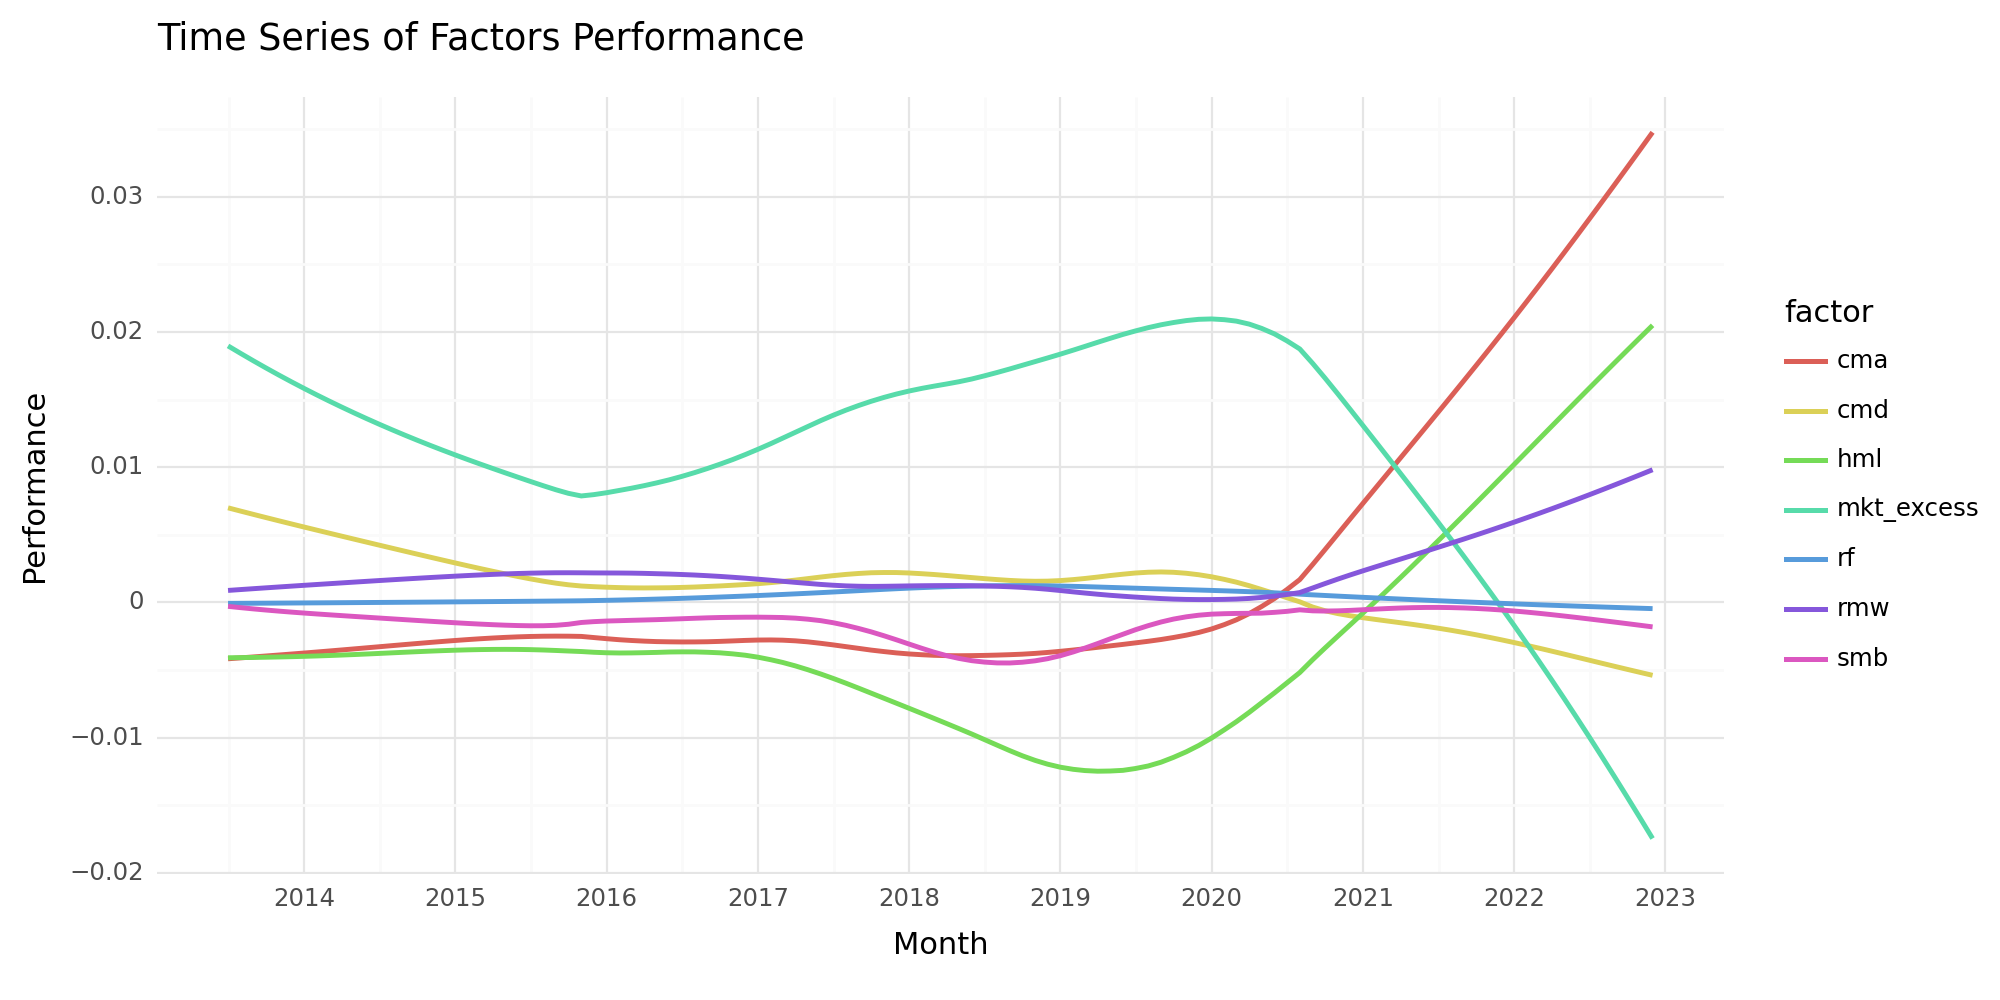

<Figure Size: (1000 x 500)>

In [160]:
(
    ggplot(factors_long, aes(x='month', y='value', color='factor')) +
    geom_smooth( span=0.5, se=False) +  #  create a smoothed line (rolling avg) of factor values
    labs(title='Time Series of Factors Performance',
         x='Month',
         y='Performance') 
    + theme_minimal()
    + scale_x_date(labels=date_format('%Y'))
    + theme( figure_size=(10, 5))
)

The time series graph presents the performance of various financial factors over time, with a particular focus on the CMD (Clean Minus Dirty) factor. This visualization allows us to observe the relative performance of cleaner firms compared to dirtier ones, alongside other factors such as market excess return, size (smb), value (hml), profitability (rmw), investment (cma), and the risk-free rate (rf).

Throughout the period from 2013 to 2023, the CMD factor has experienced fluctuations, reflecting changes in the performance differential between clean and dirty firms. Initially, the CMD factor starts at a positive value, indicating that clean firms were outperforming dirty firms at the beginning of the observed period. However, over the next few years, we observe a decline in the CMD factor, reaching a negative value around 2015-2016. This suggests that during this time, dirty firms began to outperform clean firms, potentially due to factors such as market conditions, regulatory changes, or shifts in investor sentiment.

From 2017 onwards, the CMD factor shows a relatively stable but slightly negative trend, indicating that the outperformance of dirty firms persisted for several years. Interestingly, there is a notable change around 2020, coinciding with the onset of the COVID-19 pandemic. During this period, the CMD factor starts to increase, suggesting a reversal in performance as clean firms began to recover and potentially outperform dirty firms again. This change could be attributed to increased focus on sustainability and environmental issues, as well as shifts in consumer behavior and regulatory policies favoring cleaner companies.

By the end of the observed period in 2023, the CMD factor shows a slightly positive trend, indicating that clean firms are once again starting to outperform dirty firms. This positive trajectory suggests that the market may be increasingly valuing environmental performance, possibly due to growing awareness and investment in sustainable practices.

In summary, the CMD factor has experienced significant fluctuations over the past decade, with periods of both underperformance and outperformance of clean firms relative to dirty firms. The recent trend indicates a resurgence in the performance of clean firms, likely driven by a combination of market, regulatory, and societal factors that favor environmentally sustainable practices.

The time series graph also highlights the significant changes in the market excess return (mkt_excess) over the observed period. The market excess return represents the return of the market portfolio minus the risk-free rate, providing a measure of the overall market performance relative to a risk-free investment.

In the graph, there is a noticeable sharp decline in the market excess return around 2020. This significant drop coincides with the onset of the COVID-19 pandemic, which led to unprecedented market volatility and a substantial decline in stock prices across global markets. The sharp dip reflects the severe impact of the pandemic on the financial markets, as investors faced increased uncertainty and a dramatic reduction in economic activity.

Following the initial decline, the market excess return begins to recover, demonstrating the market's resilience and gradual rebound as governments and central banks around the world implemented measures to stabilize the economy and support financial markets. This recovery period is marked by a positive upward trend in the market excess return, indicating improving market conditions and investor confidence as the global economy started to adapt to the new realities brought about by the pandemic.

The sharp fluctuations in the market excess return during this period highlight the sensitivity of the market to external shocks and the importance of macroeconomic factors in influencing overall market performance. For investors, this period underscores the need for strategies that can navigate such volatility and the potential benefits of diversifying investments to mitigate risks associated with significant market downturns.

In conclusion, the dramatic drop in the market excess return around 2020 reflects the profound impact of the COVID-19 pandemic on financial markets, followed by a period of recovery as market conditions improved. This period of volatility emphasizes the importance of understanding market dynamics and the external factors that can significantly influence market performance.

## Factor Testing

We test the new factor on a firm of our choice.   In this case we use Apple. 

In [115]:
asset_ = "AAPL"
start_date = "2010-01-01"
end_date = "2022-12-31"

In [116]:
# download asset data from yahoo finance
yf_asset_data = yf.download(asset_,
                           start=start_date,
                           end=end_date,
                           interval='1mo'
                          )

[*********************100%%**********************]  1 of 1 completed


In [118]:
yf_asset_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-01,7.622500,7.699643,6.794643,6.859286,5.799202,15168994400
2010-02-01,6.870357,7.327500,6.816071,7.307857,6.178448,10776080000
2010-03-01,7.348214,8.481429,7.337500,8.392857,7.095763,12154172800
2010-04-01,8.478929,9.730714,8.312500,9.324643,7.883547,12367129600
2010-05-01,9.422857,9.567143,7.116071,9.174286,7.756422,18082654800


Resample asset prices to month end, and calculate returns. 

In [119]:
asset_returns = (yf_asset_data["Adj Close"]
                     .resample("ME") 
                     .last() 
                     .pct_change() 
                     .dropna())
asset_returns.index = asset_returns.index.to_period("M")
asset_returns.name = "asset_ret"

In [56]:
factors.index = factors.month
factors.index = factors.index.to_period("M")

In [57]:
factors_returns_df = factors.join(asset_returns)

We calculate asset excess returns using the rf column from Fama-French.

In [58]:
factors_returns_df = (factors_returns_df
                      .assign(
                        excess_ret=lambda x: ( x["asset_ret"] - x["rf"])
                      ))

In [59]:
factors_returns_df

,month,cmd,mkt_excess,smb,hml,rmw,cma,rf,asset_ret,excess_ret
month,,,,,,,,,,
2013-07,2013-07-01,0.0113,0.0565,0.0181,0.0057,-0.0135,0.0051,0.0000,0.141225,0.141225
2013-08,2013-08-01,0.0098,-0.0271,-0.0006,-0.0269,0.0066,-0.0216,0.0000,0.083767,0.083767
2013-09,2013-09-01,0.0278,0.0377,0.0263,-0.0122,-0.0058,-0.0136,0.0000,-0.021489,-0.021489
2013-10,2013-10-01,0.0001,0.0418,-0.0148,0.0125,0.0278,0.0087,0.0000,0.096382,0.096382
2013-11,2013-11-01,-0.0103,0.0313,0.0141,0.0032,0.0014,0.0004,0.0000,0.070053,0.070053
...,...,...,...,...,...,...,...,...,...,...
2022-08,2022-08-01,0.0057,-0.0377,0.0152,0.0029,-0.0475,0.0129,0.0019,-0.031208,-0.033108
2022-09,2022-09-01,0.0061,-0.0935,-0.0105,0.0005,-0.0151,-0.0080,0.0019,-0.120977,-0.122877
2022-10,2022-10-01,0.0253,0.0783,0.0189,0.0801,0.0334,0.0664,0.0023,0.109551,0.107251


And finally, we execute a regression including our new factor.

In [122]:
fit_ff5_cmd = smf.ols(formula="excess_ret ~ mkt_excess + smb + hml + rmw + cma + cmd",
                   data=factors_returns_df).fit()
fit_ff5_cmd.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             excess_ret   R-squared:                       0.561
Model:                            OLS   Adj. R-squared:                  0.536
Method:                 Least Squares   F-statistic:                     22.76
Date:                Sun, 26 May 2024   Prob (F-statistic):           3.79e-17
Time:                        09:54:06   Log-Likelihood:                 171.37
No. Observations:                 114   AIC:                            -328.7
Df Residuals:                     107   BIC:                            -309.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0100      0.005      1.837      0.069      -0.001       0.021
mkt_excess     1.2695      0.132      9.606      0.000       1.008       1.532
smb           -0.0507      0.261     -0.194      0.846      -0.568       0.467
hml           -0.5310      0.209     -2.537      0.013      -0.946      -0.116
rmw            0.3534      0.321      1.101      0.273      -0.283       0.990
cma           -0.3205      0.344     -0.932      0.353      -1.002       0.361
cmd           -0.7897      0.398     -1.982      0.050      -1.579     1.3e-05
==============================================================================
Omnibus:                        9.070   Durbin-Watson:                   2.166
Prob(Omnibus):                  0.011   Jarque-Bera (JB):               10.520
Skew:                          -0.481   Prob(JB):                      0.00520
Kurtosis:                       4.136   Cond. No.                         89.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The regression results for Apple's (AAPL) excess returns, incorporating the newly created Clean Minus Dirty (CMD) factor along with the Fama-French factors, provide several insights. The model's R-squared value of 0.561 indicates that approximately 56.1% of the variability in Apple's excess returns is explained by the included factors, suggesting a substantial explanatory power. The adjusted R-squared of 0.536 confirms this robustness after adjusting for the number of predictors.

The market excess return (mkt_excess) has a highly significant positive coefficient of 1.2695 (p < 0.0001), indicating that Apple's returns are strongly driven by overall market movements. The size factor (smb) and profitability factor (rmw) do not show significant impacts on Apple's returns, with p-values of 0.846 and 0.273, respectively.

The value factor (hml) has a significant negative coefficient of -0.5310 (p = 0.013), suggesting that Apple tends to behave more like a growth stock, which is consistent with its high growth profile. The investment factor (cma) also shows no significant effect (p = 0.353).

Notably, the CMD factor has a negative coefficient of -0.7897, which is significant at the 0.05 level (p = 0.050). This indicates that higher environmental cleanliness, as captured by the CMD factor, is associated with lower excess returns for Apple. This could suggest that Apple's stock performance is negatively impacted by factors that are favorable from an environmental perspective, or it might reflect market perceptions and valuations related to environmental performance.

Overall, the regression results highlight the strong influence of market returns and the significant negative impact of the CMD factor on Apple's excess returns, providing important insights into how environmental factors are affecting Apple's stock performance.

## Comparison of CAPM, FF5 and FF5+CMD

Finally, to show the value of our new factor in this example, we create a comparison table that shows the CAPM, FF5 and our new factor. 

In [124]:
from IPython.display import HTML, display
from stargazer.stargazer import Stargazer

We need regression fits for the CAPM and FF5.

In [121]:
fit_capm = smf.ols(formula="excess_ret ~ mkt_excess",
                   data=factors_returns_df).fit()
fit_ff5 = smf.ols(formula="excess_ret ~ mkt_excess + smb + hml + rmw + cma",
                   data=factors_returns_df).fit()

In [125]:
# Create a Stargazer object
stargazer = Stargazer([fit_capm, fit_ff5, fit_ff5_cmd])

# Set custom configurations if needed
stargazer.title('Regression Results')
stargazer.custom_columns(['CAPM', 'FF5', 'FF5 + CMD'], [1, 1, 1])
stargazer.add_custom_notes([''])

# Render HTML (useful for Jupyter Notebooks) or get LaTeX code
html_output = stargazer.render_html()
#print(html_output) 
display(HTML(html_output))

The comparison of the CAPM, FF5, and FF5 + CMD models on Apple's excess returns reveals several key insights into the factors influencing its stock performance.

In the CAPM model (Column 1), the market excess return (mkt_excess) is highly significant (p < 0.01) with a coefficient of 1.214, indicating a strong positive relationship between Apple's returns and market movements. The intercept is also significant at the 5% level, suggesting a modest positive excess return when the market return is zero. This model explains approximately 45.1% of the variability in Apple's excess returns (R² = 0.451).

Moving to the FF5 model (Column 2), the inclusion of additional factors improves the explanatory power, raising the R² to 0.545. The market excess return remains highly significant with a coefficient of 1.239. Among the added factors, the value factor (hml) is significantly negative (p < 0.05), indicating that Apple behaves more like a growth stock. The profitability factor (rmw) shows marginal significance (p < 0.1), suggesting some influence on returns, while the investment factor (cma) and size factor (smb) are not significant.

In the FF5 + CMD model (Column 3), the CMD factor, representing environmental cleanliness, is introduced. This model achieves the highest R² of 0.561, indicating that 56.1% of the variability in Apple's excess returns is explained by the model. The CMD factor itself is significant at the 10% level (p < 0.1) with a negative coefficient of -0.790, suggesting that Apple's returns are negatively impacted by higher environmental cleanliness. This might reflect market perceptions and valuations related to environmental performance. The market excess return remains highly significant and positive, while the value factor (hml) continues to show a significant negative relationship with Apple's returns. The intercept remains modestly significant, while the size (smb) and profitability (rmw) factors are not significant in this model.

Overall, the inclusion of the CMD factor in the FF5 model slightly improves the explanatory power, highlighting the potential relevance of environmental factors in analyzing Apple's stock performance. The results suggest that while market movements and value characteristics are primary drivers, environmental cleanliness also plays a notable role.

# Assignment

Create a new factor for Social Governance and test it on an asset or index of your choice.  
- Create a hypothesis of how you expect the factor to influence your asset.
- Does this factor actually correlate with the returns of your asset?
- What potential issues and biases are you facing in ESG research?
- What issues are you facing with regards to the factor models? (Hint - think through the regression assumptions, are they met?)

Create a report with a minimum of one graph and one table for your results.  In your report, briefly develop an hypothesis based on the literature and reason how your findings correspond to your expectations. 

For some inspiration on theoretical frameworks, take a look at the papers listed on this site: 
https://wrds-www.wharton.upenn.edu/pages/news/sp-esg-data-enables-access-to-a-deep-range-of-environmental-social-and-governance-factors/

## How to Download ESG Data

For this week's assignment you will need to access ESG data from WRDS.   This section gives you an example of how can accomplish this, but you'll need to change the example to read social governance data, the example reads environmental data.  The dataset description for ESG scores available here:

https://wrds-www.wharton.upenn.edu/pages/support/manuals-and-overviews/compustat/trucost-esg/wrds-overview-of-sp-esg-trucost/

In [4]:
# show the first few rows of the wrds_esg table from trucost
pd.read_sql_query(
  sql="SELECT * from trucost.wrds_esg LIMIT 5",
  con=wrds_engine,
  dtype={"institutionid": int}
)

,scoreid,dimensionscoreid,criteriascoreid,questionscoreid,institutionid,assessmentyear,scoredate,mostrecentsequence,csaindustrymapid,csaindustryname,csaindustrygroupname,csaindustryclassificationname,csasectorname,campaignname,campaignstartdate,campaignenddate,campaigntypename,campaigntypecode,csasharinglevelname,csascoretypename,scoretype,dimensionname,aspectname,criterianote,scorevalue,scoreweight,scoreyoy,industryrank,scoreest,scoreestwtd,msacaseid,msacasedate,msacasetitle,msacasescore,msacaseimpactlevelname,msacaseimpactrating,msacaseresponsename,msacaseresponserating,msaimpactid,msaimpactdate,criteriascoreimpact
0,5A1E6322-1057-42E2-BEBB-DED5A53D6884,BF23BB3C-1169-42C0-A1AD-41A1DC65CBFA,None,None,15333,2022,2023-03-17,1,C0F2A1B7-C793-4320-BEB1-C54524337F22,INS Insurance,Insurance,SAM GICS,Financials,Non-Listed Companies SA 2022,2022-06-23,2023-03-31,Public Assessment,SA,All,Modeled,S&P Global ESG Score,S&P Global ESG Score,S&P Global ESG Score,None,17,NaN,None,237.0,0,7.0,None,None,None,None,None,None,None,None,None,None,None
1,5A1E6322-1057-42E2-BEBB-DED5A53D6884,BF23BB3C-1169-42C0-A1AD-41A1DC65CBFA,B8E71257-155C-44F6-8D8E-144D0DE170DD,D54A2853-685E-4CEA-9A86-341F4E298DEE,15333,2022,2023-03-17,1,C0F2A1B7-C793-4320-BEB1-C54524337F22,INS Insurance,Insurance,SAM GICS,Financials,Non-Listed Companies SA 2022,2022-06-23,2023-03-31,Public Assessment,SA,All,Modeled,Question,Environmental Dimension,Climate Risk Assessment - Transition Risks,None,10,5.0,None,206.0,100,NaN,None,None,None,None,None,None,None,None,None,None,None
2,5A1E6322-1057-42E2-BEBB-DED5A53D6884,BF23BB3C-1169-42C0-A1AD-41A1DC65CBFA,B8E71257-155C-44F6-8D8E-144D0DE170DD,B53F283D-BF69-465E-83D4-B28627DFD38F,15333,2022,2023-03-17,1,C0F2A1B7-C793-4320-BEB1-C54524337F22,INS Insurance,Insurance,SAM GICS,Financials,Non-Listed Companies SA 2022,2022-06-23,2023-03-31,Public Assessment,SA,All,Modeled,Question,Environmental Dimension,Climate Risk Management,None,46,19.0,None,236.0,100,NaN,None,None,None,None,None,None,None,None,None,None,None
3,5A1E6322-1057-42E2-BEBB-DED5A53D6884,BF23BB3C-1169-42C0-A1AD-41A1DC65CBFA,B8E71257-155C-44F6-8D8E-144D0DE170DD,80B48B9F-AB6C-413C-A96E-C393116F25A2,15333,2022,2023-03-17,1,C0F2A1B7-C793-4320-BEB1-C54524337F22,INS Insurance,Insurance,SAM GICS,Financials,Non-Listed Companies SA 2022,2022-06-23,2023-03-31,Public Assessment,SA,All,Modeled,Question,Environmental Dimension,Climate-Related Management Incentives,None,26,23.0,None,185.0,100,NaN,None,None,None,None,None,None,None,None,None,None,None
4,5A1E6322-1057-42E2-BEBB-DED5A53D6884,BF23BB3C-1169-42C0-A1AD-41A1DC65CBFA,B8E71257-155C-44F6-8D8E-144D0DE170DD,194F91BA-6B32-45EC-9475-C3B68A9EE782,15333,2022,2023-03-17,1,C0F2A1B7-C793-4320-BEB1-C54524337F22,INS Insurance,Insurance,SAM GICS,Financials,Non-Listed Companies SA 2022,2022-06-23,2023-03-31,Public Assessment,SA,All,Modeled,Question,Environmental Dimension,Climate-Related Scenario Analysis,None,9,5.0,None,209.0,100,NaN,None,None,None,None,None,None,None,None,None,None,None


In [5]:
# show all dimensions that we have scores available for
pd.read_sql_query(
  sql="SELECT DISTINCT(scoretype) from trucost.wrds_esg",
  con=wrds_engine,
)

,scoretype
0,Criteria
1,Dimension
2,Question
3,S&P Global ESG Score


In [6]:
# show all aspects available for the Dimensions
pd.read_sql_query(
  sql="SELECT DISTINCT(aspectname) from trucost.wrds_esg WHERE scoretype = 'Dimension'",
  con=wrds_engine,
)

,aspectname
0,Economic Governance Dimension
1,Environmental Dimension
2,Social Dimension


In [7]:
pd.read_sql_query(
  sql="SELECT * from trucost.wrds_esg WHERE aspectname = 'Environmental Dimension' LIMIT 5",
  con=wrds_engine,
  dtype={"institutionid": int}
)

,scoreid,dimensionscoreid,criteriascoreid,questionscoreid,institutionid,assessmentyear,scoredate,mostrecentsequence,csaindustrymapid,csaindustryname,csaindustrygroupname,csaindustryclassificationname,csasectorname,campaignname,campaignstartdate,campaignenddate,campaigntypename,campaigntypecode,csasharinglevelname,csascoretypename,scoretype,dimensionname,aspectname,criterianote,scorevalue,scoreweight,scoreyoy,industryrank,scoreest,scoreestwtd,msacaseid,msacasedate,msacasetitle,msacasescore,msacaseimpactlevelname,msacaseimpactrating,msacaseresponsename,msacaseresponserating,msaimpactid,msaimpactdate,criteriascoreimpact
0,5A1E6322-1057-42E2-BEBB-DED5A53D6884,BF23BB3C-1169-42C0-A1AD-41A1DC65CBFA,None,None,15333,2022,2023-03-17,1,C0F2A1B7-C793-4320-BEB1-C54524337F22,INS Insurance,Insurance,SAM GICS,Financials,Non-Listed Companies SA 2022,2022-06-23,2023-03-31,Public Assessment,SA,All,Modeled,Dimension,Environmental Dimension,Environmental Dimension,None,15,20,None,228.0,0.0,14.0,None,None,None,None,None,None,None,None,None,None,None
1,5A1E6322-1057-42E2-BEBB-DED5A53D6884,8A7E1056-DCD4-49A6-A7F7-E3C9E67D5D91,None,None,15333,2022,2023-03-17,1,C0F2A1B7-C793-4320-BEB1-C54524337F22,INS Insurance,Insurance,SAM GICS,Financials,Non-Listed Companies SA 2022,2022-06-23,2023-03-31,Public Assessment,SA,All,Raw,Dimension,Environmental Dimension,Environmental Dimension,None,1,20,None,200.0,NaN,NaN,None,None,None,None,None,None,None,None,None,None,None
2,0890C137-0594-4AF8-88DE-3D1DC6486F16,D771B176-CC98-4C06-9BD1-E7891BD10F1B,None,None,15358,2022,2023-02-17,1,A3159D02-1F40-48A8-9461-E845645192B6,HEA Health Care Providers & Services,Health Care Equipment & Services,SAM GICS,Health Care,Non-Listed Companies SA 2022,2022-06-23,2023-03-31,Public Assessment,SA,All,Modeled,Dimension,Environmental Dimension,Environmental Dimension,None,16,11,None,142.0,0.0,15.0,None,None,None,None,None,None,None,None,None,None,None
3,0890C137-0594-4AF8-88DE-3D1DC6486F16,E18AE677-6BAE-49B2-84E9-28E2350E88A8,None,None,15358,2022,2023-02-17,1,A3159D02-1F40-48A8-9461-E845645192B6,HEA Health Care Providers & Services,Health Care Equipment & Services,SAM GICS,Health Care,Non-Listed Companies SA 2022,2022-06-23,2023-03-31,Public Assessment,SA,All,Raw,Dimension,Environmental Dimension,Environmental Dimension,None,1,11,None,153.0,NaN,NaN,None,None,None,None,None,None,None,None,None,None,None
4,7AF1AEF8-57C6-492F-BC41-C2198F31D97B,64D04CEB-7B70-4049-841A-50FE908E08D5,None,None,15866,2022,2023-03-17,1,C0F2A1B7-C793-4320-BEB1-C54524337F22,INS Insurance,Insurance,SAM GICS,Financials,Non-Listed Companies SA 2022,2022-06-23,2023-03-31,Public Assessment,SA,All,Modeled,Dimension,Environmental Dimension,Environmental Dimension,None,13,20,None,243.0,0.0,12.0,None,None,None,None,None,None,None,None,None,None,None


The primary identifier is institutionid, which is available in nearly every table. This is the same Institution ID used in SNL databases and can be used to link there directly. wrds_companies contains a map from Institution ID to companyid (the primary Capital IQ identifier) and gvkey (the primary Compustat identifier).

In [8]:
pd.read_sql_query(
  sql="SELECT * from trucost.wrds_companies LIMIT 1",
  con=wrds_engine,
  dtype={"institutionid": int, "gvkey":str}
)

,institutionid,companyid,gvkey,ticker,companyname,status,companytype,simpleindustry,incorporation_country,country,incorporation_state,state,streetaddress,streetaddress2,streetaddress3,streetaddress4,zipcode,yearfounded,monthfounded,dayfounded,officephonevalue,otherphonevalue,officefaxvalue,webpage
0,4,412184943.0,None,None,Columbia Universal Financial Corporation,Operating Subsidiary,Private Company,None,United States,United States,DE,TX,None,None,None,None,None,1989,None,None,None,None,None,None


In [23]:
pd.read_sql_query(
  sql="SELECT * \
       FROM trucost.wrds_companies as companies \
       WHERE companies.institutionid = '15333'  \
       AND companies.gvkey IS NOT NULL ",
  con=wrds_engine,
  dtype={"institutionid": int}
)

,institutionid,companyid,gvkey,ticker,companyname,status,companytype,simpleindustry,incorporation_country,country,incorporation_state,state,streetaddress,streetaddress2,streetaddress3,streetaddress4,zipcode,yearfounded,monthfounded,dayfounded,officephonevalue,otherphonevalue,officefaxvalue,webpage
0,15333,164194.0,123556,None,The Guardian Life Insurance Company of America,Operating,Private Company,Insurance,United States,United States,NY,NY,10 Hudson Yards,None,None,None,10001,1860,None,None,212 598 8000,None,None,www.guardianlife.com


In [21]:
environment_scores = pd.read_sql_query(
  sql="SELECT * \
       FROM trucost.wrds_esg as esg \
       WHERE esg.aspectname = 'Environmental Dimension' \
       AND esg.institutionid = '15333' \
       AND esg.csascoretypename = 'Raw' ",
  con=wrds_engine,
  dtype={"institutionid": int}
)

environment_scores

,scoreid,dimensionscoreid,criteriascoreid,questionscoreid,institutionid,assessmentyear,scoredate,mostrecentsequence,csaindustrymapid,csaindustryname,csaindustrygroupname,csaindustryclassificationname,csasectorname,campaignname,campaignstartdate,campaignenddate,campaigntypename,campaigntypecode,csasharinglevelname,csascoretypename,scoretype,dimensionname,aspectname,criterianote,scorevalue,scoreweight,scoreyoy,industryrank,scoreest,scoreestwtd,msacaseid,msacasedate,msacasetitle,msacasescore,msacaseimpactlevelname,msacaseimpactrating,msacaseresponsename,msacaseresponserating,msaimpactid,msaimpactdate,criteriascoreimpact
0,5A1E6322-1057-42E2-BEBB-DED5A53D6884,8A7E1056-DCD4-49A6-A7F7-E3C9E67D5D91,None,None,15333,2022,2023-03-17,1,C0F2A1B7-C793-4320-BEB1-C54524337F22,INS Insurance,Insurance,SAM GICS,Financials,Non-Listed Companies SA 2022,2022-06-23,2023-03-31,Public Assessment,SA,All,Raw,Dimension,Environmental Dimension,Environmental Dimension,None,1,20,None,200.0,None,None,None,None,None,None,None,None,None,None,None,None,None


In [24]:
environment_scores = pd.read_sql_query(
  sql="SELECT esg.institutionid as institutionid, esg.assessmentyear as year, esg.aspectname as aspect, esg.scorevalue as score, \
              esg.csascoretypename, \
              companies.gvkey as gvkey \
       FROM trucost.wrds_esg as esg \
       LEFT JOIN trucost.wrds_companies as companies \
       ON esg.institutionid = companies.institutionid \
       WHERE esg.aspectname = 'Environmental Dimension' \
       AND esg.csascoretypename = 'Raw'  \
       AND companies.gvkey IS NOT NULL",
  con=wrds_engine,
  dtype={"institutionid": int}
)

environment_scores

,institutionid,year,aspect,score,csascoretypename,gvkey
0,15333,2022,Environmental Dimension,1,Raw,123556
1,15866,2022,Environmental Dimension,1,Raw,121633
2,100003,2016,Environmental Dimension,10,Raw,024447
3,100201,2017,Environmental Dimension,61,Raw,002968
4,100003,2017,Environmental Dimension,8,Raw,024447
...,...,...,...,...,...,...
85226,105814353,2023,Environmental Dimension,0,Raw,353070
85227,106357406,2023,Environmental Dimension,10,Raw,353626
85228,106554287,2023,Environmental Dimension,10,Raw,041716
85229,107074371,2023,Environmental Dimension,15,Raw,041539


In [64]:
# get permno for gvkey, so we can link with CRSP later
envcrsp_links = (environment_scores
  .merge(ccmxpf_linktable, how="inner", on="gvkey")
  .query("~gvkey.isnull()")
  .assign(
    sorting_date=lambda x: (pd.to_datetime(
        x.year.apply(lambda x: str(x)+"0701" ))
    ),
  )
  .get(["permno", "sorting_date", "aspect", "score"])
)

In [65]:
envcrsp_links

,permno,sorting_date,aspect,score
0,76892,2016-07-01,Environmental Dimension,10
1,47896,2017-07-01,Environmental Dimension,61
2,76892,2017-07-01,Environmental Dimension,8
3,47896,2019-07-01,Environmental Dimension,49
4,76892,2018-07-01,Environmental Dimension,0
...,...,...,...,...
32239,22264,2022-07-01,Environmental Dimension,0
32240,48961,2021-07-01,Environmental Dimension,0
32241,23433,2023-07-01,Environmental Dimension,10
32242,23343,2023-07-01,Environmental Dimension,15
